In [1]:
import torch
import time
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from colpali_engine.models import ColQwen2_5, ColQwen2_5_Processor
from colpali_engine.interpretability import get_similarity_maps_from_embeddings, plot_similarity_map
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from sentence_transformers import SentenceTransformer, util
import stamina
import json
import os
from io import BytesIO
import requests

# Configuration
DATASET_PATH = "./data_images"
COLLECTION_NAME = "colqwen_attention"
QUERY_IMAGE_PATH = "./data_images/similar.png"
BATCH_SIZE = 2
TOP_K = 3
OUTPUT_FILE = "evaluation_report.json"

def init_qdrant():
    """Initialize Qdrant client and create collection."""
    client = QdrantClient(":memory:")
    client.create_collection(
        collection_name=COLLECTION_NAME,
        on_disk_payload=True,
        vectors_config=models.VectorParams(
            size=128,
            distance=models.Distance.COSINE,
            on_disk=True,
            multivector_config=models.MultiVectorConfig(comparator=models.MultiVectorComparator.MAX_SIM),
            quantization_config=models.BinaryQuantization(binary=models.BinaryQuantizationConfig(always_ram=True)),
        ),
    )
    return client

def init_models():
    """Initialize ColQwen2.5 and VLM models."""
    model = ColQwen2_5.from_pretrained("vidore/colqwen2.5-v0.2", torch_dtype=torch.bfloat16, device_map="cuda:0").eval()
    processor = ColQwen2_5_Processor.from_pretrained("vidore/colqwen2.5-v0.2")
    vlm = Qwen2_5_VLForConditionalGeneration.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="float16", device_map="cuda:1")
    vlm_processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct-AWQ", use_fast=True)
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
    return model, processor, vlm, vlm_processor, sentence_model

@stamina.retry(on=Exception, attempts=3)
def upsert_to_qdrant(client, points):
    """Upsert points to Qdrant."""
    client.upsert(collection_name=COLLECTION_NAME, points=points, wait=False)
    return True

def index_dataset(client, dataset, model, processor):
    """Index dataset images in Qdrant."""
    for i in range(0, len(dataset['train']), BATCH_SIZE):
        batch = dataset['train'][i:i + BATCH_SIZE]
        images = batch['image']
        with torch.no_grad():
            batch_images = processor.process_images(images).to(model.device)
            embeddings = model(**batch_images)
        points = [
            models.PointStruct(
                id=i + j,
                vector=embedding.cpu().float().numpy().tolist(),
                payload={"source": "Attention is all you need"}
            )
            for j, embedding in enumerate(embeddings)
        ]
        upsert_to_qdrant(client, points)
    client.update_collection(
        collection_name=COLLECTION_NAME,
        optimizer_config=models.OptimizersConfigDiff(indexing_threshold=10),
    )

def query_text(client, query, model, processor, top_k=1):
    """Query Qdrant with text."""
    with torch.no_grad():
        batch_query = processor.process_queries([query]).to(model.device)
        query_embedding = model(**batch_query)
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()
    start_time = time.time()
    search_result = client.query_points(
        collection_name=COLLECTION_NAME,
        query=multivector_query,
        limit=top_k,
        timeout=100,
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(ignore=False, rescore=True, oversampling=2.0)
        ),
    )
    latency = time.time() - start_time
    return [
        {"id": point.id, "score": point.score, "image": dataset['train'][point.id]["image"], "latency": latency}
        for point in search_result.points
    ]


In [2]:

def query_image(client, image_to_query, model, processor, top_k=TOP_K):
    """Query Qdrant with an image."""
    image_to_query = image_to_query.convert("RGB")
    with torch.no_grad():
        batch_query = processor.process_images([image_to_query]).to(model.device)
        query_embedding = model(**batch_query)
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()
    start_time = time.time()
    search_result = client.query_points(
        collection_name=COLLECTION_NAME,
        query=multivector_query,
        limit=top_k,
        timeout=100,
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(ignore=False, rescore=True, oversampling=2.0)
        ),
    )
    latency = time.time() - start_time
    return [
        {"id": point.id, "score": point.score, "image": dataset['train'][point.id]["image"], "latency": latency}
        for point in search_result.points
    ]


In [3]:


def describe_image(image, vlm, vlm_processor, question="What is the name of the attention function of this image?"):
    """Generate image description using VLM."""
    messages = [{"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": question}]}]
    text = vlm_processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = vlm_processor(text=[text], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt").to("cuda:1")
    generated_ids = vlm.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    return vlm_processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

def evaluate_response(query, response, retrieved_image, latency, sentence_model):
    """Evaluate response against ground truth."""
    ground_truth = {
        "How is the scaled dot-product attention calculated?": (
            "Scaled dot-product attention is calculated as: Attention(Q, K, V) = softmax(QK^T / sqrt(d_k))V, "
            "where Q, K, V are queries, keys, and values, and d_k is the dimension of keys."
        ),
        "What is the BLEU score of the model in English to German translation EN-DE?": (
            "The BLEU score for English to German (EN-DE) translation is 28.4 for the Transformer model."
        ),
        "How long were the base and big models trained?": (
            "The base model was trained for 100,000 steps (approximately 3.5 days on 8 P100 GPUs), "
            "and the big model was trained for 300,000 steps."
        ),
        "Which optimizer was used when training the models?": (
            "The Adam optimizer was used with beta1=0.9, beta2=0.98, and epsilon=10^-9."
        ),
        "Show me a picture that shows the difference between Scaled Dot-Product Attention and Multi-Head Attention.": (
            "An image showing the difference between Scaled Dot-Product Attention and Multi-Head Attention, "
            "typically Figure 2 in the paper, illustrating single-head vs. multi-head mechanisms."
        ),
    }
    key_concepts = {
        "How is the scaled dot-product attention calculated?": ["softmax", "qk^t", "sqrt(d_k)", "values"],
        "What is the BLEU score of the model in English to German translation EN-DE?": ["28.4", "bleu"],
        "How long were the base and big models trained?": ["100,000", "300,000", "3.5 days"],
        "Which optimizer was used when training the models?": ["adam", "beta1", "beta2", "epsilon"],
        "Show me a picture that shows the difference between Scaled Dot-Product Attention and Multi-Head Attention.": [
            "figure 2", "multi-head", "scaled dot-product"
        ],
    }
    evaluation = {"query": query, "response": response, "latency": latency, "accuracy": 0.0, "completeness": 0.0, "relevance": 0.0}
    
    if query in ground_truth:
        if query == list(ground_truth.keys())[-1]:
            evaluation["accuracy"] = 1.0 if "figure 2" in response.lower() or "multi-head" in response.lower() else 0.5
        else:
            gt_embedding = sentence_model.encode(ground_truth[query], convert_to_tensor=True)
            resp_embedding = sentence_model.encode(response, convert_to_tensor=True)
            evaluation["accuracy"] = min(util.cos_sim(gt_embedding, resp_embedding).item(), 1.0)
        
        concepts = key_concepts[query]
        matches = sum(1 for concept in concepts if concept in response.lower())
        evaluation["completeness"] = min(matches / len(concepts), 1.0)
    
    evaluation["relevance"] = 1.0 if retrieved_image and ("attention" in query.lower() or query == list(ground_truth.keys())[-1]) else 0.5 if response else 0.0
    return evaluation

def show_results(image_to_query, results):
    """Display query image and top-k results."""
    k = min(len(results), 3)
    fig = plt.figure(figsize=(18, 24))
    gs = GridSpec(2, k, figure=fig, height_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_title("Query Image", fontsize=18)
    ax1.imshow(image_to_query.convert("RGB"))
    ax1.axis("off")
    for i, result in enumerate(results[:k]):
        im = result["image"].convert("RGB")
        ax = fig.add_subplot(gs[1, i])
        ax.set_title(f"ID {result['id']}, Score: {result['score']:.4f}", fontsize=14)
        ax.imshow(im)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def load_image_from_url(url):
    """Load image from URL."""
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

def generate_similarity_map(image, query, model, processor, token_idx=3):
    """Generate similarity map for a query token."""
    batch_images = processor.process_images([image]).to(model.device)
    batch_queries = processor.process_queries([query]).to(model.device)
    with torch.no_grad():
        image_embeddings = model(**batch_images)
        query_embeddings = model(**batch_queries)
    n_patches = processor.get_n_patches(image.size, model.spatial_merge_size)
    image_mask = processor.get_image_mask(batch_images)
    similarity_maps = get_similarity_maps_from_embeddings(image_embeddings, query_embeddings, n_patches, image_mask)[0]
    query_content = processor.decode(batch_queries.input_ids[0]).replace(processor.tokenizer.pad_token, "").replace(processor.query_augmentation_token, "").strip()
    query_tokens = processor.tokenizer.tokenize(query_content)
    if token_idx < len(query_tokens):
        current_similarity_map = similarity_maps[token_idx]
        fig, ax = plot_similarity_map(image, current_similarity_map, figsize=(8, 8), show_colorbar=False)
        max_sim_score = similarity_maps[token_idx, :, :].max().item()
        ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)
        plt.show()


In [4]:


"""Run multimodal RAG pipeline."""
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
dataset = load_dataset("./data_images")
client = init_qdrant()
model, processor, vlm, vlm_processor, sentence_model = init_models()

print("Indexing dataset...")
index_dataset(client, dataset, model, processor)

print("Running text queries...")
queries = [
    "How is the scaled dot-product attention calculated?",
    "What is the BLEU score of the model in English to German translation EN-DE?",
    "How long were the base and big models trained?",
    "Which optimizer was used when training the models?",
    "Show me a picture that shows the difference between Scaled Dot-Product Attention and Multi-Head Attention."
]
text_results = []
for query in queries:
    results = query_text(client, query, model, processor)
    image = results[0]["image"] if results else None
    response = describe_image(image, vlm, vlm_processor, query) if image else ""
    evaluation = evaluate_response(query, response, image, results[0]["latency"] if results else 0.0, sentence_model)
    text_results.append(evaluation)



Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Indexing dataset...
Running text queries...


In [5]:

print("Running image query...")
image_to_query = Image.open(QUERY_IMAGE_PATH).resize((512, 512))
image_to_query

Running image query...


FileNotFoundError: [Errno 2] No such file or directory: './data_images/similar.png'

In [ ]:

image_results = query_image(client, image_to_query, model, processor)
image_results

[{'id': 15,
  'score': 244.98917232248147,
  'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=102x97>,
  'latency': 0.04525637626647949},
 {'id': 3,
  'score': 223.58353257177328,
  'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
  'latency': 0.04525637626647949},
 {'id': 2,
  'score': 202.5515316468073,
  'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
  'latency': 0.04525637626647949}]

ID: 15, Score: 244.9892
Description: The attention function in the image is called "MatMul" followed by "SoftMax".
ID: 3, Score: 223.5835
Description: The attention function shown in the left part of Figure 2 is called "Scaled Dot-Product Attention."
ID: 2, Score: 202.5515
Description: The attention function in the image is called "Multi-Head Attention."


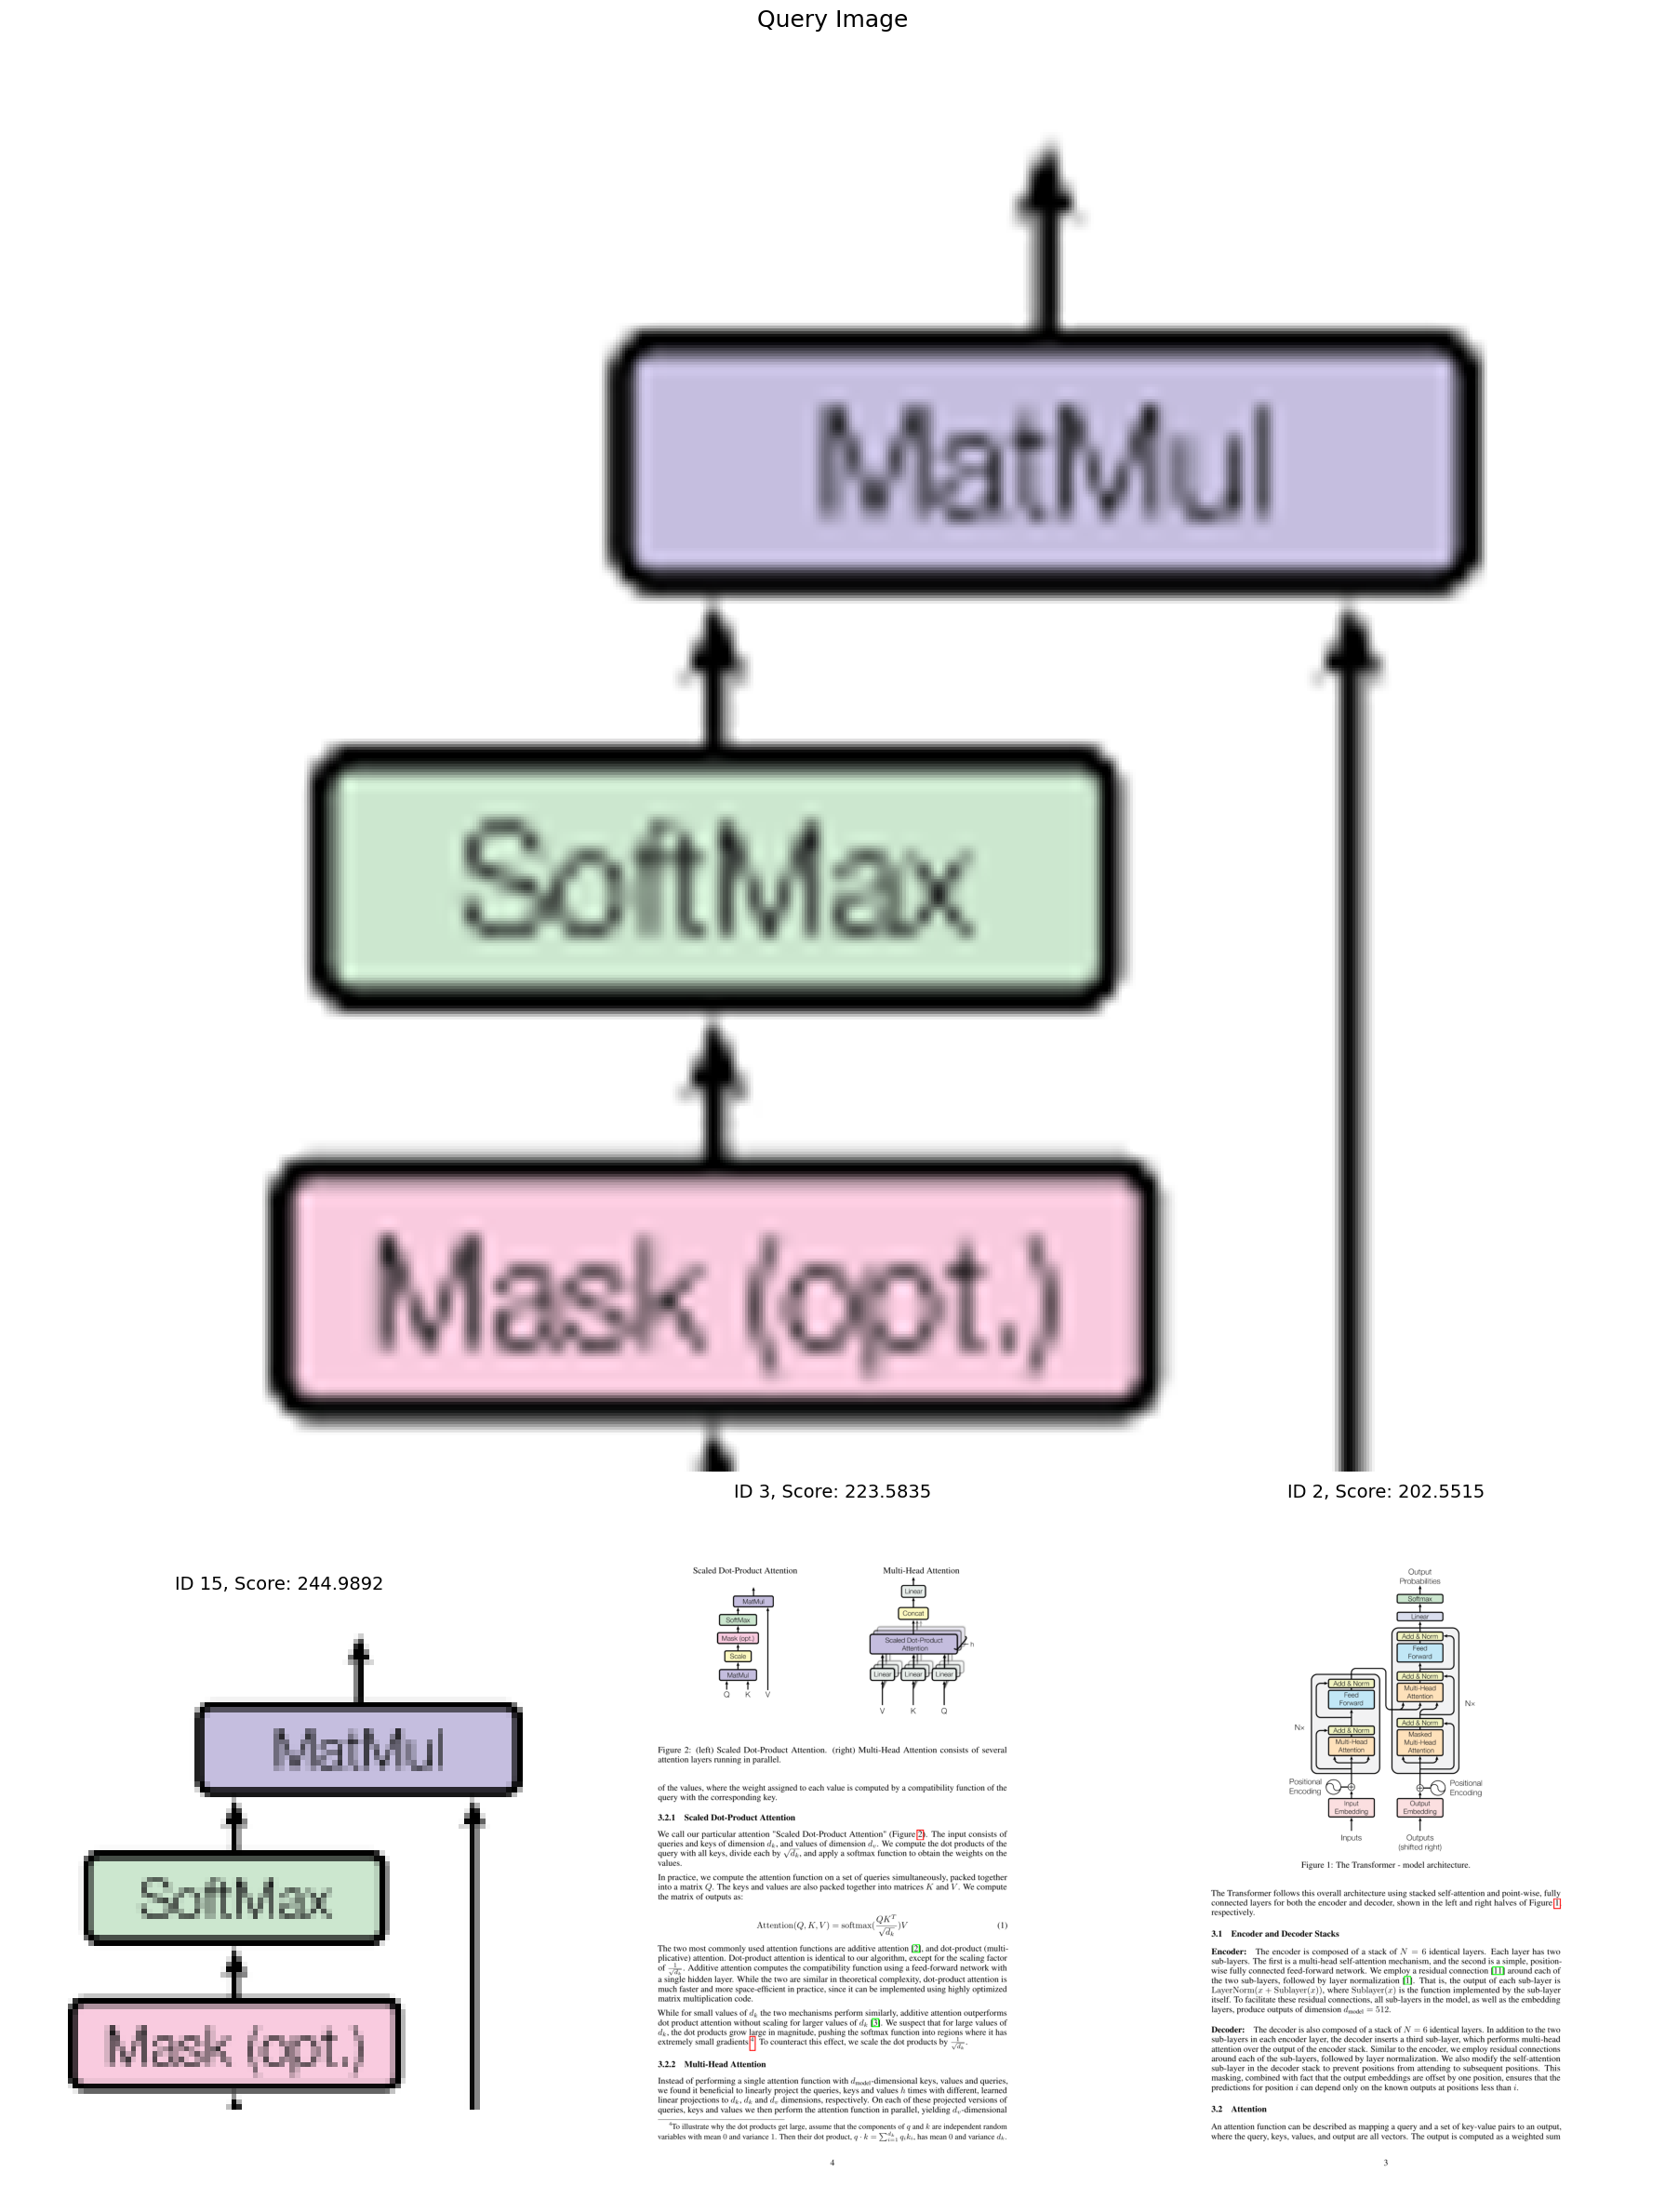

In [ ]:

for result in image_results:
    print(f"ID: {result['id']}, Score: {result['score']:.4f}")
    description = describe_image(result["image"], vlm, vlm_processor)
    print(f"Description: {description}")
show_results(image_to_query, image_results)


Generating similarity map...


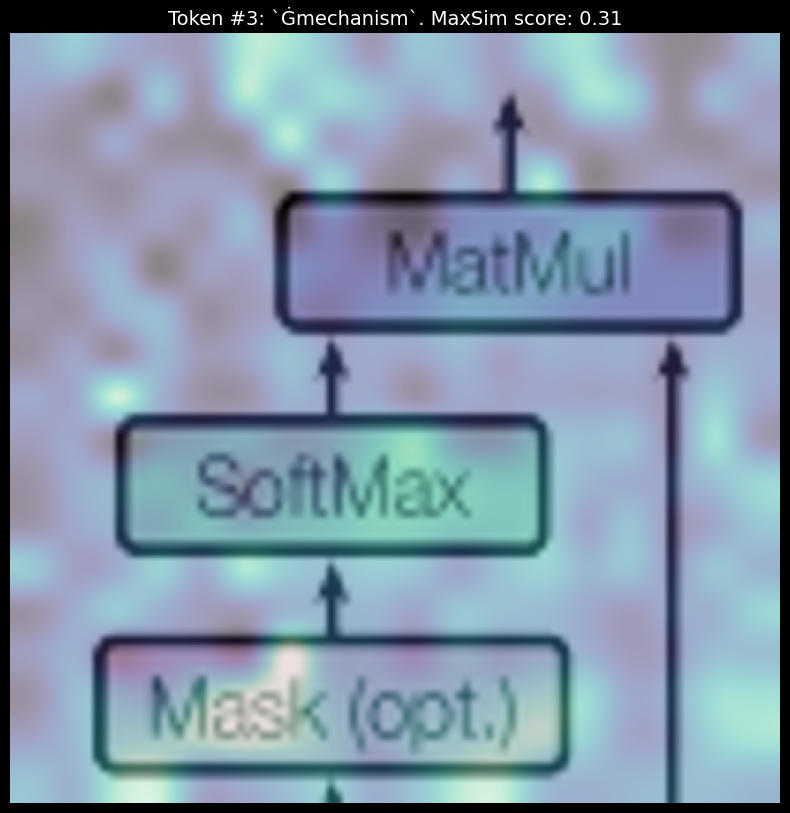

Saving evaluation results...
Evaluation Summary:

Query: How is the scaled dot-product attention calculated?
Response: The scaled dot-product attention is calculated by first computing the dot products of the query with all keys, dividing each by \(\sqrt{d_k}\), and then applying a softmax function to obtain the weights on the values. The formula for this is given by:

\[
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\]

Here:
- \(Q\) is the query matrix.
- \(K\) is the key matrix.
- \(V\) is the value matrix.
- \(d_k\) is
Accuracy: 0.89, Completeness: 0.75, Relevance: 1.00, Latency: 0.01s

Query: What is the BLEU score of the model in English to German translation EN-DE?
Response: The BLEU score of the model in English to German translation (EN-DE) is 27.3.
Accuracy: 0.87, Completeness: 0.50, Relevance: 0.50, Latency: 0.01s

Query: How long were the base and big models trained?
Response: The base models were trained for 100,000 steps or 12 hours, whil

In [ ]:

print("Generating similarity map...")
generate_similarity_map(image_to_query, "Attention mechanism visualization", model, processor)

print("Saving evaluation results...")
image_evaluation = {
    "query": "What is the name of the attention function of this image",
    "response": describe_image(image_results[0]["image"], vlm, vlm_processor) if image_results else "",
    "latency": image_results[0]["latency"] if image_results else 0.0,
    "image_query_accuracy": 1.0 if image_results and any(x in describe_image(image_results[0]["image"], vlm, vlm_processor).lower() for x in ["scaled dot-product", "multi-head"]) else 0.0
}
evaluation_report = {"query_results": text_results, "image_query_result": image_evaluation}
with open(OUTPUT_FILE, "w") as f:
    json.dump(evaluation_report, f, indent=2)

print("Evaluation Summary:")
for result in text_results:
    print(f"\nQuery: {result['query']}")
    print(f"Response: {result['response']}")
    print(f"Accuracy: {result['accuracy']:.2f}, Completeness: {result['completeness']:.2f}, Relevance: {result['relevance']:.2f}, Latency: {result['latency']:.2f}s")
print(f"\nImage Query: {image_evaluation['query']}")
print(f"Response: {image_evaluation['response']}")
print(f"Image Query Accuracy: {image_evaluation['image_query_accuracy']:.2f}, Latency: {image_evaluation['latency']:.2f}s")

